<Figure size 1200x400 with 0 Axes>

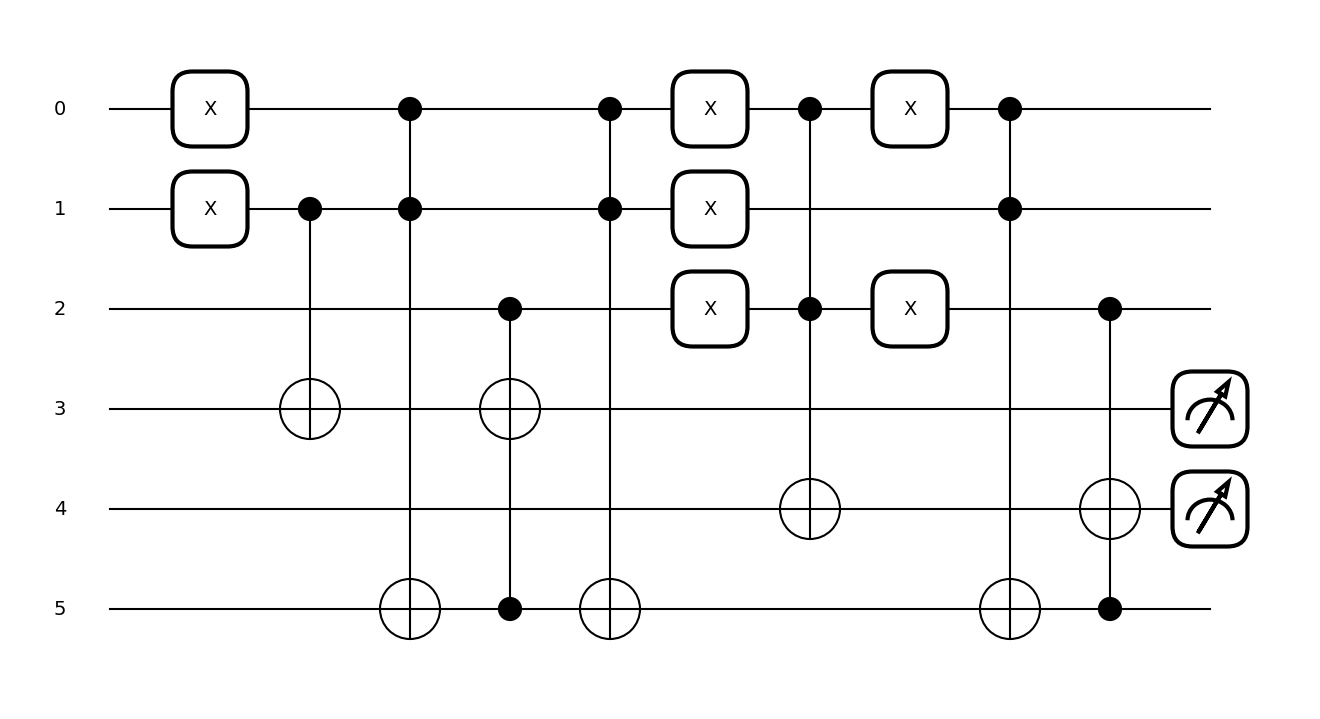

In [8]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# We now use 6 wires:
# wires 0,1,2: input bits (a, b, c)
# wire 3: output for f
# wire 4: output for g
# wire 5: ancilla for multi-controlled gates
n_wires = 6
dev = qml.device("default.qubit", wires=n_wires, shots=1024)
    
@qml.qnode(dev)
def oracle_circuit(inputs):
    """
    Oracle implementing:
      f(a,b,c) = ¬b ∧ (a ∨ ¬c)
      g(a,b,c) = (a ∧ ¬c) ∨ (¬a ∧ b ∧ c)
      
    This circuit uses only Hadamard, PauliX, CNOT, and Toffoli gates.
    """
    # --- Prepare the input state on wires 0, 1, 2 (a, b, c) ---
    for i, bit in enumerate(inputs):
        if bit == 1:
            qml.PauliX(wires=i)
    
    ### Compute f on wire 3 = ¬b ∧ (a ∨ ¬c)
    # If b == 0 then set f to 1.
    # Use an X on wire 1 to control on b == 0.
    qml.PauliX(wires=1)         # b: 0 -> 1 (control becomes active)
    qml.CNOT(wires=[1, 3])      # If flipped b==1, then flip f.
    #qml.PauliX(wires=1)        # Restore b, this I could remove for further optimization.
    
    # Subtract the unwanted case when (a ∨ ¬c) is false,
    # i.e. when a==0 and c==1, but only when b==0.
    # For this, we need to condition on b==0, a==0, and c==1.
    # We flip b and a to control on 0.
    #qml.PauliX(wires=1)        # Flip b: now b==0 becomes 1, this I could remove for further optimization.
    qml.PauliX(wires=0)         # Flip a: now a==0 becomes 1.
    
    # Now, if flipped b (wire 1), flipped a (wire 0), and c (wire 2) are all 1,
    # Compute the AND of the first two controls into ancilla.
    qml.Toffoli(wires=[1, 0, 5])
    # Use ancilla and third control to flip the target.
    qml.Toffoli(wires=[5, 2, 3])
    # Uncompute the ancilla.
    qml.Toffoli(wires=[1, 0, 5])
    
    qml.PauliX(wires=0)         # Restore a.
    qml.PauliX(wires=1)         # Restore b.
    
    ### Compute g on wire 4 = (a ∧ ¬c) ∨ (¬a ∧ b ∧ c)
    # Term 1: If a==1 and c==0 then flip g.
    qml.PauliX(wires=2)         # Flip c so that c==0 becomes 1 (control on ¬c).
    qml.Toffoli(wires=[0, 2, 4])
    qml.PauliX(wires=2)         # Restore c.
    
    # Term 2: If a==0, b==1, and c==1 then flip g.
    qml.PauliX(wires=0)         # Flip a so that a==0 becomes 1 (control on ¬a).

    # Compute the AND of the first two controls into ancilla.
    qml.Toffoli(wires=[0, 1, 5])
    # Use ancilla and third control to flip the target.
    qml.Toffoli(wires=[5, 2, 4])
    
    return qml.sample(wires=[3, 4])

# Draw the circuit for one example (e.g. inputs = [0, 0, 0])
plt.figure(figsize=(12, 4))
circuit_drawer = qml.draw_mpl(oracle_circuit)
circuit_drawer([0, 0, 0])
plt.show()


In [17]:
def test_oracle():
    """Verify that the oracle returns the correct outputs for each input.
    
    The truth table is defined as a list of tuples:
      (a, b, c, expected_f, expected_g)
    where `None` means "don't care".
    """
    truth_table = [
        (0, 0, 0, 1, None),  # For (0,0,0): f=1, g is don't care.
        (0, 0, 1, None, 0),
        (0, 1, 0, 0, 0),
        (0, 1, 1, 0, 1),
        (1, 0, 0, 1, 1),
        (1, 0, 1, 1, 0),
        (1, 1, 0, None, 1),
        (1, 1, 1, 0, None)
    ]
    
    for a, b, c, expected_f, expected_g in truth_table:
        # Run the circuit for the given input triple.
        # (The circuit returns an array of shape (shots, 2).)
        result = oracle_circuit([a, b, c])
        
        # Take the majority vote (via mean and rounding) over the shots.
        f = int(np.round(np.mean(result[:, 0])))
        g = int(np.round(np.mean(result[:, 1])))
        
        if expected_f is not None:
            assert f == expected_f, (
                f"Failed for input (a={a}, b={b}, c={c}): "
                f"expected f={expected_f}, got f={f}"
            )
        if expected_g is not None:
            assert g == expected_g, (
                f"Failed for input (a={a}, b={b}, c={c}): "
                f"expected g={expected_g}, got g={g}"
            )
    print("All tests passed!")

# Run the test function.
test_oracle()


All tests passed!


<Figure size 1200x400 with 0 Axes>

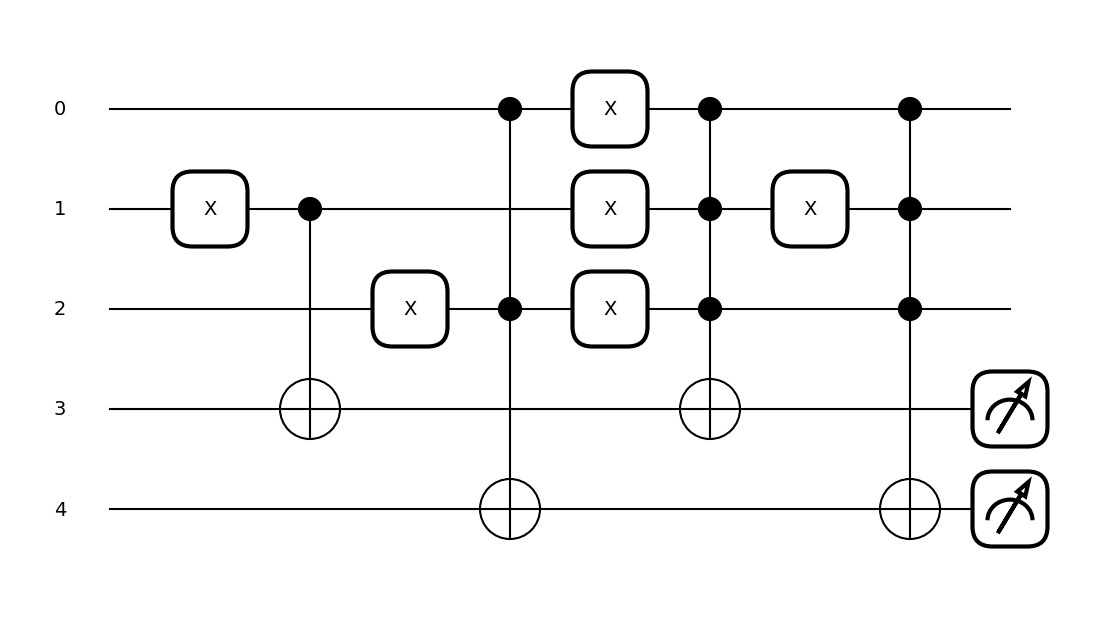

In [16]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Use 5 wires:
#   wires 0,1,2: input bits (a, b, c)
#   wire 3: output for f
#   wire 4: output for g
n_wires = 5
dev = qml.device("default.qubit", wires=n_wires, shots=1024)

@qml.qnode(dev)
def optimized_oracle(inputs):
    """
    Implements:
      f(a,b,c) = ¬b ∧ (a ∨ ¬c)
      g(a,b,c) = (a ∧ ¬c) ∨ (¬a ∧ b ∧ c)
      
    This version uses only 5 wires and 10 gate layers.
    
    To reduce X gates we “bundle” flips around the multi–qubit operations:
      • For the f subtraction and g term2 blocks, we need to flip wire 0 (a)
        so that a==0 becomes 1. Instead of flipping a, undoing it, then re–flipping
        it for the next block, we flip a once at the start of the block and restore it
        only at the end.
      • Similarly, we combine the two X’s on wire 1 (which were used to prepare f–subtraction)
        into a single “restore” after the f subtraction MCX.
    
    (The single–qubit X gates that occur in parallel in a single layer aren’t counted separately.)
    """
    # --- Prepare the input state on wires 0,1,2 (a, b, c) ---
    for i, bit in enumerate(inputs):
        if bit:
            qml.PauliX(wires=i)
    
    #############################################
    # Layer 1: f–setting
    # To set f=1 when b==0, we flip b (so 0→1) and use a CNOT.
    qml.PauliX(wires=1)
    qml.CNOT(wires=[1, 3])
    # (At this point, b is still flipped relative to the original.)
    
    #############################################
    # Layer 2: g term1
    # We want to flip g when a==1 and c==0.
    # Flip c so that c==0 becomes 1, then apply a Toffoli (controls a and flipped c).
    qml.PauliX(wires=2)
    qml.Toffoli(wires=[0, 2, 4])
    qml.PauliX(wires=2)
    
    #############################################
    # Layers 3–5: Combined block for:
    #  • f subtraction: subtract (flip) f when (a,b,c)==(0,0,1) originally, and
    #  • g term2: add (flip) g when (a,b,c)==(0,1,1) originally.
    #
    # Originally, to get these conditions we had:
    #   - f subtraction: flip both a and b, then MCX on f, then restore b.
    #   - g term2: flip a, then MCX on g, then restore a.
    #
    # Here we “bundle” the flips on a:
    #   1. Flip a and b to prepare for f subtraction.
    #   2. Apply MCX on f.
    #   3. Restore b.
    #   4. (Keep a flipped so that it serves for g term2.)
    #   5. Apply MCX on g.
    #   6. Finally, restore a.
    qml.PauliX(wires=0)   # Flip a (once) for both blocks.
    qml.PauliX(wires=1)   # Flip b to convert a==0, b==0 into controls=1.
    
    qml.MultiControlledX(wires=[0, 1, 2, 3])  # f subtraction: fires when controls (a,b,c)==(1,1,1),
                                              # i.e. originally (a,b,c)==(0,0,1).
    
    qml.PauliX(wires=1)   # Restore b (so that for g term2, b reflects its original value).
    
    qml.MultiControlledX(wires=[0, 1, 2, 4])  # g term2: fires when (a,b,c)==(1,1,1),
                                              # which (with a still flipped) corresponds to originally (0,1,1).
    
    return qml.sample(wires=[3, 4])

# Draw the circuit for one example (e.g. inputs = [0, 0, 0])
plt.figure(figsize=(12, 4))
circuit_drawer = qml.draw_mpl(optimized_oracle)
circuit_drawer([0, 0, 0])
plt.show()
